In [29]:
import numpy as np
from scipy.misc import imresize
import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patchess
import matplotlib.gridspec as gridspec
from skimage import transform, filters
import sys, pylab, operator, csv
#import util
import os
import urllib

%matplotlib notebook
plt.rcParams["font.family"] = "Times New Roman"
pylab.rc('font', serif='Times New Roman')
%load_ext autoreload
%autoreload 2

import caffe

from helpers import *
from heatmaps import *
from repro_EB_figs import *
from optimize_mask import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
gpu = 0
net_type = 'googlenet'

In [31]:
caffe.set_device(gpu)
caffe.set_mode_gpu()

net = get_net(net_type)

# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_spl

In [32]:
labels_desc = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_words.txt', str, delimiter='\t')
synsets = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t')
(paths, labels) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/annotated_train_heldout_imdb.txt')
data_desc = 'train_heldout'
paths = np.array(paths)
labels = np.array(labels)
ann_dir = '/data/ruthfong/ILSVRC2012/annotated_train_heldout_ground_truth_annotations'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])
res_dir = '/data/ruthfong/neural_coding/pycaffe_results'
mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
#mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
mask_paths = [os.path.join(res_dir, mask_rel_dir, '%d.npy' % x) for x in range(len(labels))]
fig_dir = '/home/ruthfong/neural_coding/paper_figures'

# Splash Figure

In [33]:
def generate_splash_img(path, label, mask_path, perturbation = 'blur', fig_path = None):
    net_transformer = get_ILSVRC_net_transformer(net)

    target = np.zeros(1000)
    target[label] = 1

    orig_img = caffe.io.load_image(path)
    img_ = net_transformer.preprocess('data', orig_img)
    if perturbation == 'blur':
        null_img_ = net_transformer.preprocess('data', get_blurred_img(path, radius = 10))
    elif perturbation == 'mean_img':
        null_img_ = np.zeros(img_.shape)
    elif perturbation == 'random_noise':
        null_img_ = np.random.random(img_.shape)*255

    mask = np.load(mask_path)
    comp_img_ = img_ * mask + null_img_ * (1 - mask)
    comp_img_r = imresize(net_transformer.deprocess('data', comp_img_), orig_img.shape[:2])
    mask_r = imresize(mask, orig_img.shape[:2])/float(255)

    orig_score = forward_pass(net, img_, target)
    blur_score = forward_pass(net, comp_img_, target)

    f, ax = plt.subplots(1,3)
    ax[0].imshow(orig_img)
    ax[0].set_title('%s: %.4f' % (get_short_class_name(label), orig_score), fontname="Times New Roman")
    ax[1].imshow(comp_img_r)
    ax[1].set_title('%s: %.4f' % (get_short_class_name(label), blur_score), fontname="Times New Roman")
    #ax[2].imshow(orig_img)
    #ax[2].imshow(mask_r, cmap='jet')
    ax[2].imshow(mask_r)
    ax[2].set_title('Learned Mask', fontname="Times New Roman")
    for a in ax:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
    plt.tight_layout()
    if fig_path is not None:
        plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.0)

In [34]:
from matplotlib.font_manager import findfont,findSystemFonts, FontProperties
font = findfont(FontProperties(family=['Times New Roman']))
font

u'/home/ruthfong/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [35]:
print [i for i in findSystemFonts(fontpaths=None, fontext='ttf')]

[u'/usr/share/fonts/stix/STIX-BoldItalic.otf', u'/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', u'/usr/share/fonts/dejavu/DejaVuSansMono-BoldOblique.ttf', u'/usr/share/fonts/dejavu/DejaVuSans-ExtraLight.ttf', u'/usr/share/fonts/stix/STIX-Italic.otf', u'/usr/share/fonts/dejavu/DejaVuSans.ttf', u'/usr/share/fonts/stix/STIX-Bold.otf', u'/usr/share/fonts/dejavu/DejaVuSansCondensed.ttf', u'/usr/share/fonts/dejavu/DejaVuSansMono-Oblique.ttf', u'/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', u'/usr/share/fonts/stix/STIX-Regular.otf', u'/usr/share/fonts/dejavu/DejaVuSansMono.ttf', u'/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf', u'/usr/share/fonts/dejavu/DejaVuSansCondensed-BoldOblique.ttf', u'/usr/share/fonts/dejavu/DejaVuSansMono-Bold.ttf', u'/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf', u'/usr/share/fonts/dejavu/DejaVuSans-Oblique.ttf', u'/usr/share/fonts/dejavu/DejaVuSans-BoldOblique.ttf', u'/usr/share/fonts/abattis-cantarell/Cantarell-Regular.otf']


<IPython.core.display.Javascript object>


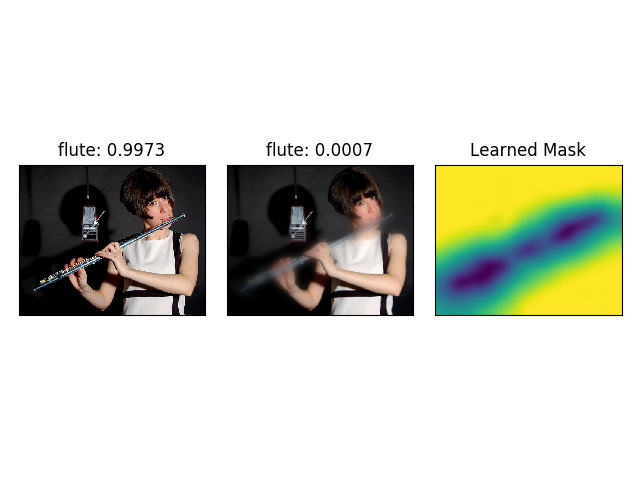

In [36]:
ind = 7
fig_path = os.path.join(fig_dir, 'splash_%d.pdf' % ind)
generate_splash_img(paths[ind], labels[ind], mask_paths[ind], 'blur', fig_path)

# Template Matching Figure
(Simonyan et al., 2014)

In [43]:
def show_saliency_map(net, img_path, label, ann_path = None, gpu = None, fig_path = None):
    transformer = get_ILSVRC_net_transformer(net)
    heatmap = compute_heatmap(net, transformer, img_path, label, 'saliency', 'loss3/classifier', 'loss3/classifier',
                        outputBlobName = 'data', outputLayerName = 'data', norm_deg = np.inf, gpu = gpu)
    img = caffe.io.load_image(img_path)
    f, ax = plt.subplots(1,2)
    ax[0].imshow(img)
    if ann_path is not None:
        objs = load_objs(ann_path)
        for k in objs.keys():
            for i in range(len(objs[k])):
                bb_coords = objs[k][i]
                rect = patches.Rectangle((bb_coords[0],bb_coords[1]),bb_coords[2]-bb_coords[0],bb_coords[3]-bb_coords[1],
                             linewidth=1,edgecolor='r',facecolor='none')
                ax[0].add_patch(rect)
    ax[0].set_title(get_short_class_name(label))
    ax[1].imshow(imresize(heatmap, img.shape[:2])/float(255))
    ax[1].set_title('gradient')
    for a in ax:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
    #plt.tight_layout()
    f.subplots_adjust(wspace=0.05)
    if fig_path is not None:
        plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.0)

<IPython.core.display.Javascript object>


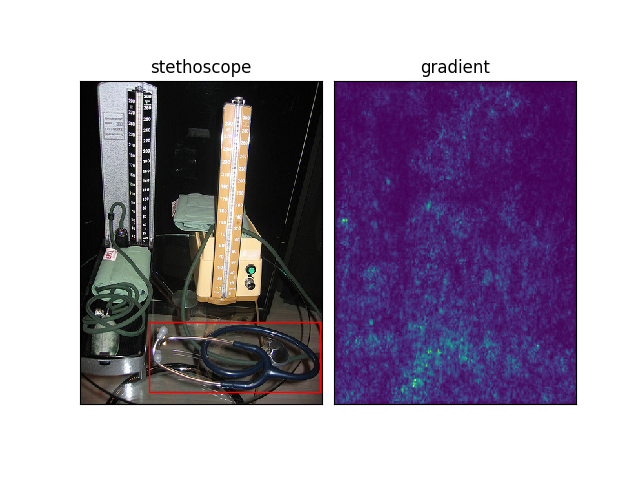

<IPython.core.display.Javascript object>


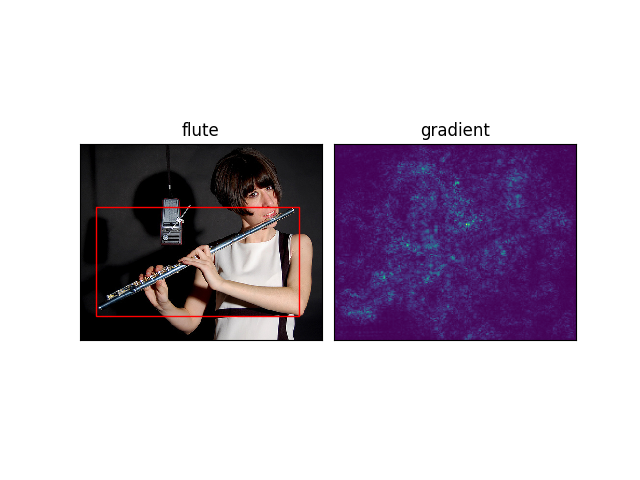

<IPython.core.display.Javascript object>


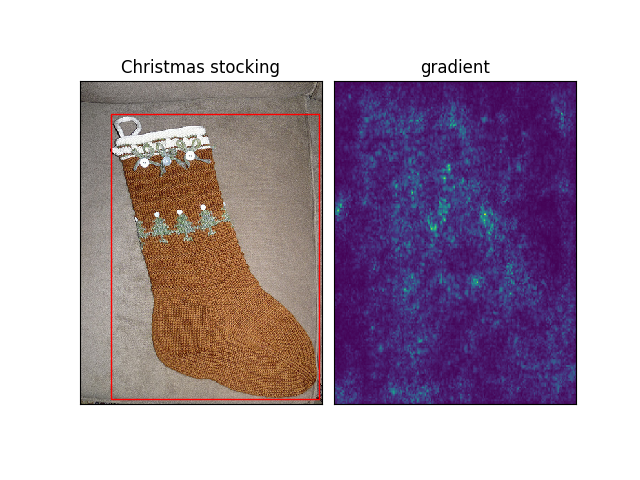

<IPython.core.display.Javascript object>


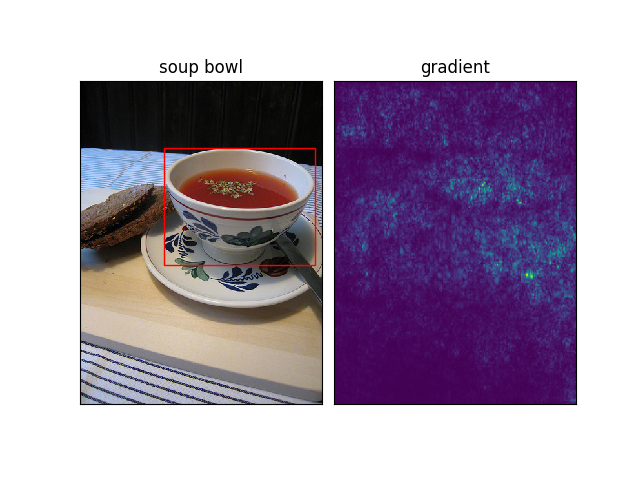

In [44]:
for i in [0,7,13,14]:
    show_saliency_map(net, paths[i], labels[i], ann_paths[i], gpu, 
                     os.path.join(fig_dir, 'saliency_%d.pdf' % i))

# Perturbations Figure

In [47]:
constant_mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_mean_img/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
constant_mask_paths = [os.path.join(res_dir, constant_mask_rel_dir, '%d.npy' % x) for x in range(len(labels))]
noise_mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_random_noise/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
noise_mask_paths = [os.path.join(res_dir, noise_mask_rel_dir, '%d.npy' % x) for x in range(len(labels))]

In [50]:
def generate_perturbations_figure(transformer, img_path, mask_paths, show_masks = False, 
                                  fig_path = None): 
                                  #label = None, ann_path = None):
    assert(len(mask_paths) == 3)
    orig_img = caffe.io.load_image(img_path)
    orig_img_ = transformer.preprocess('data', orig_img)
    blur_img_ = transformer.preprocess('data', blur(orig_img))
    constant_img_ = np.zeros(orig_img_.shape)
    rand_img_ = np.random.random(orig_img_.shape)*255
    null_imgs_ = [blur_img_, constant_img_, rand_img_]
    if show_masks:
        f, ax = plt.subplots(1,len(mask_paths))
        #f, ax = plt.subplots(2,len(mask_paths))
        #gs = gridspec.GridSpec(2,len(mask_paths))
    else:
        f, ax = plt.subplots(1,len(mask_paths))
        #gs = gridspec.GridSpec(1,len(mask_paths))
    #gs.update(wspace=0.05,hspace=0.05)
    disp_name=['blur','constant','noise']
    for i in range(len(mask_paths)):
        mask = np.load(mask_paths[i])
        comp_img_r = imresize(transformer.deprocess('data', 
                                    orig_img_ * mask + null_imgs_[i] * (1 - mask)),
                                    orig_img.shape[:2])
        mask_r = imresize(mask, orig_img.shape)
        if show_masks:
            ax[i].imshow(mask_r)
            ax[i].get_xaxis().set_visible(False)
            ax[i].get_yaxis().set_visible(False)

            #ax[0][i].imshow(comp_img_r)
            #ax[1][i].imshow(mask_r)
            #ax[0][i].get_xaxis().set_visible(False)
            #ax[0][i].get_yaxis().set_visible(False)
            #ax[1][i].get_xaxis().set_visible(False)
            #ax[1][i].get_yaxis().set_visible(False)
            
            #ax[0][i].set_aspect('equal')
            #ax[1][i].set_aspect('equal')
        else:
            ax[i].imshow(comp_img_r)
            ax[i].set_title(disp_name[i])
            ax[i].get_xaxis().set_visible(False)
            ax[i].get_yaxis().set_visible(False)
            #ax[i].set_aspect('equal')
    f.subplots_adjust(wspace=0.05)
    #plt.tight_layout()
    if fig_path is not None:
        plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.0)

<IPython.core.display.Javascript object>


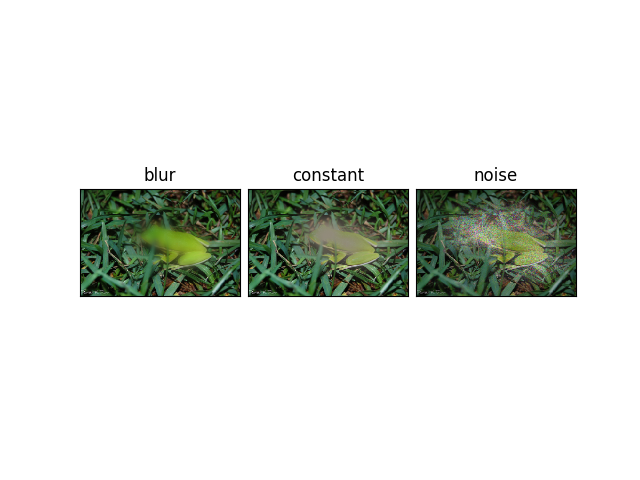

<IPython.core.display.Javascript object>


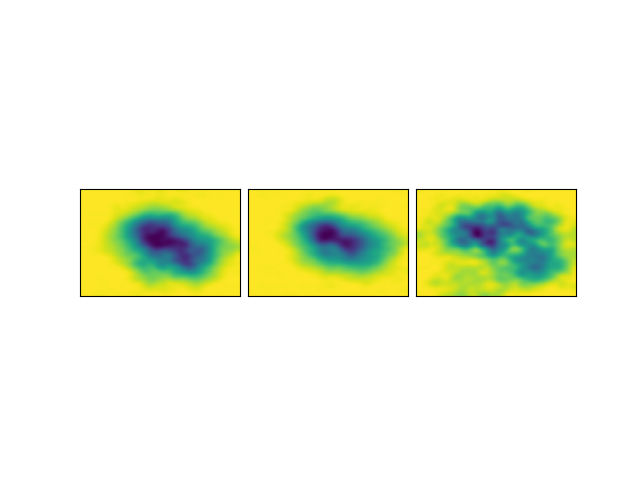

<IPython.core.display.Javascript object>


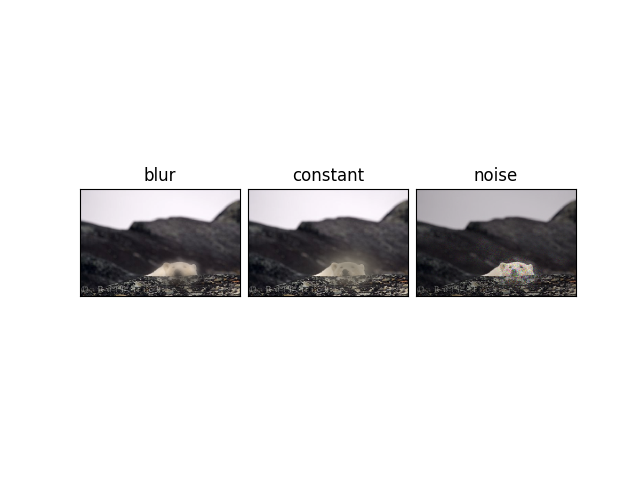

<IPython.core.display.Javascript object>


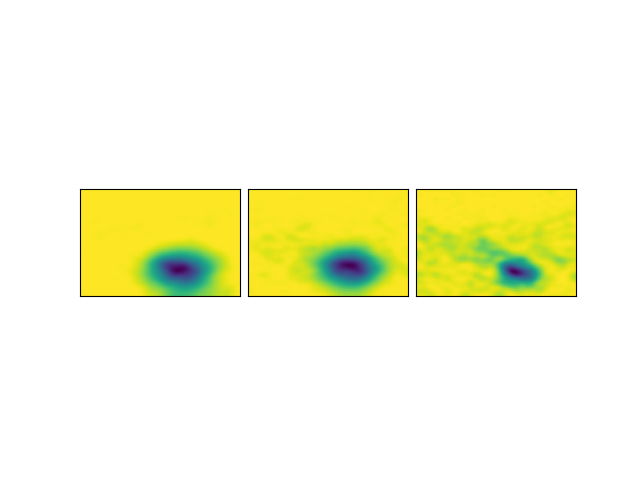

<IPython.core.display.Javascript object>


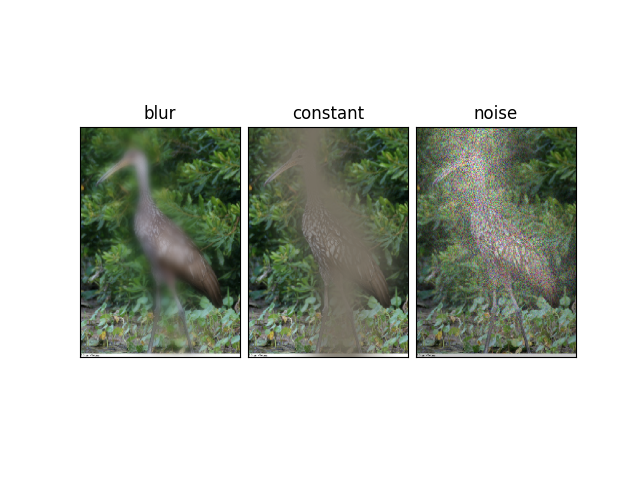

<IPython.core.display.Javascript object>


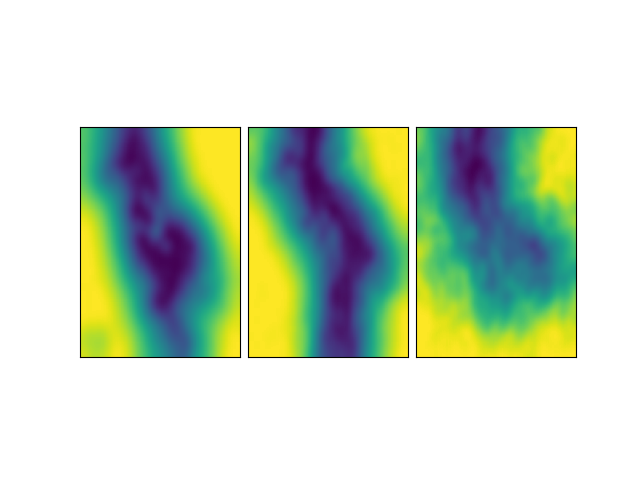

<IPython.core.display.Javascript object>


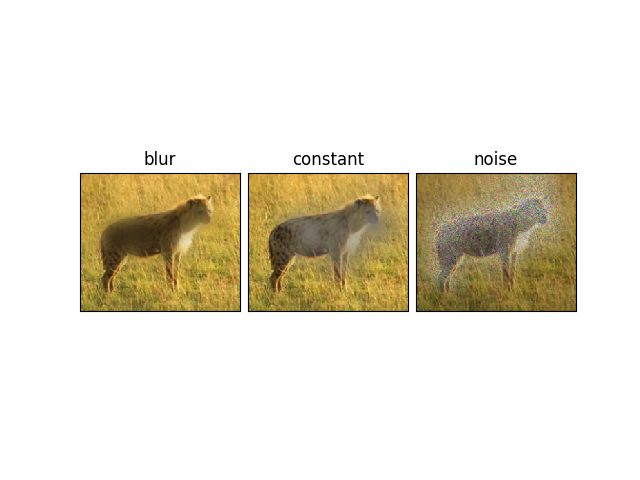

<IPython.core.display.Javascript object>


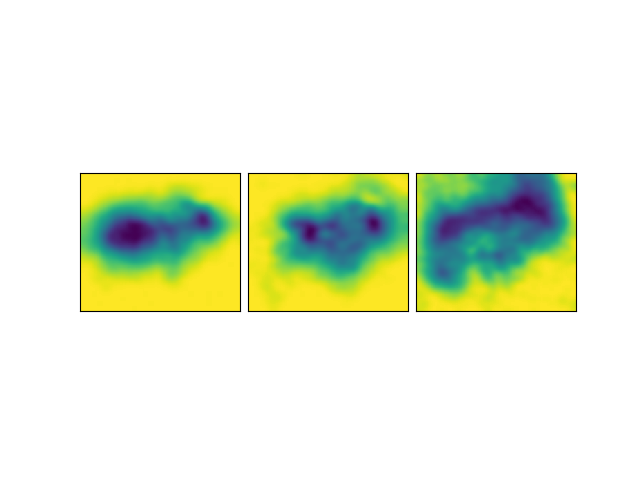

<IPython.core.display.Javascript object>


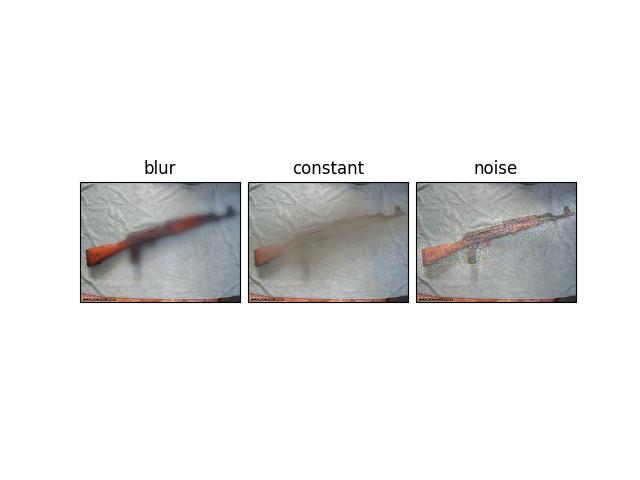

<IPython.core.display.Javascript object>


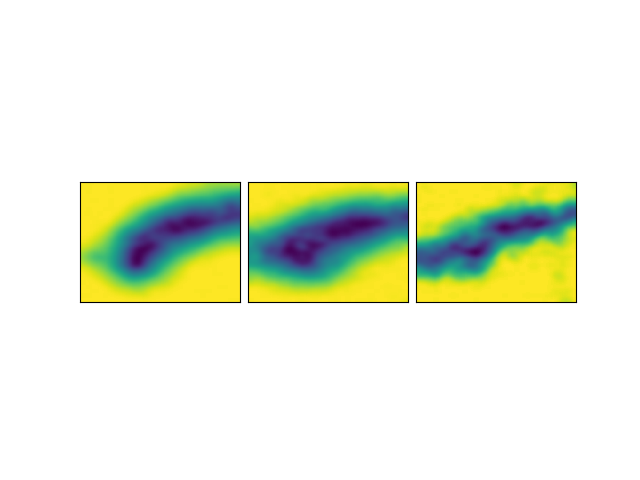

In [51]:
transformer = get_ILSVRC_net_transformer(net)
for i in [31,50,67,71,87]:
    generate_perturbations_figure(transformer, paths[i], 
                                  [mask_paths[i], constant_mask_paths[i], noise_mask_paths[i]],
                                  show_masks = False,
                                  fig_path = os.path.join(fig_dir, 'perturbations_%d.pdf' % i))
    generate_perturbations_figure(transformer, paths[i], 
                                  [mask_paths[i], constant_mask_paths[i], noise_mask_paths[i]],
                                  show_masks = True,
                                  fig_path = os.path.join(fig_dir, 'perturbation_masks_%d.pdf' % i))

# Artifacts Figure

<IPython.core.display.Javascript object>


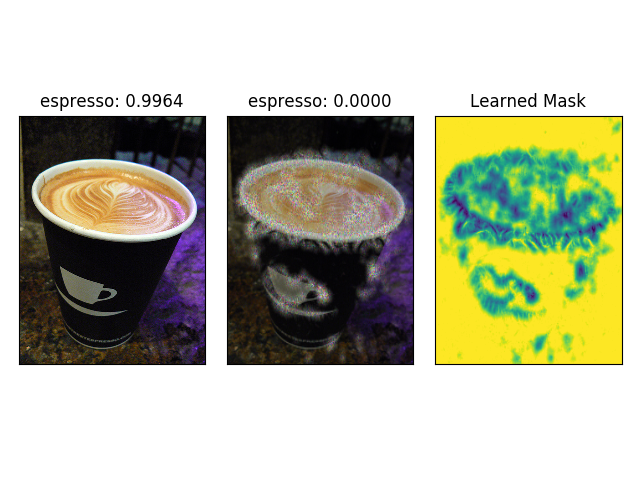

<IPython.core.display.Javascript object>


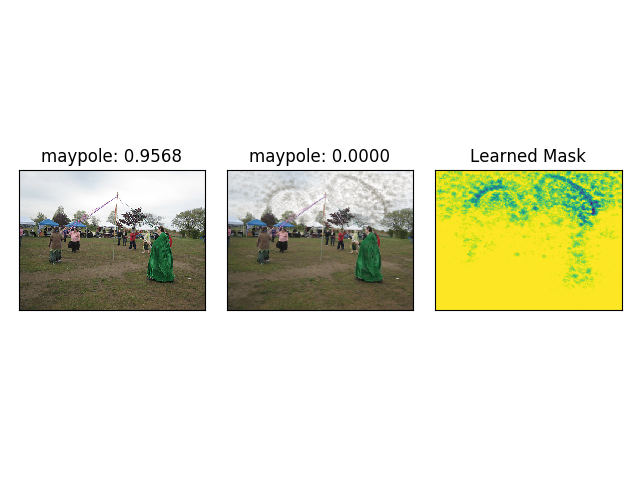

In [18]:
generate_splash_img(paths[9], labels[9], '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_avg_blur_blank_noise/lr_0_l1_lambda_-5.00_tv_lambda_-3.00_beta_3.00_jitter_4_noise_-3.0_num_iters_300_tv2/9.npy', 
                    perturbation = 'random_noise', fig_path = os.path.join(fig_dir, 'artifacts_random_noise_9.pdf'))
generate_splash_img(paths[4], labels[4], '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_mean_img/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_1_blur_mask_0_jitter_4_noise_-inf_num_iters_300_tv2/4.npy', 
                   perturbation = 'mean_img', fig_path = os.path.join(fig_dir, 'artifacts_constant_4.pdf'))

<IPython.core.display.Javascript object>


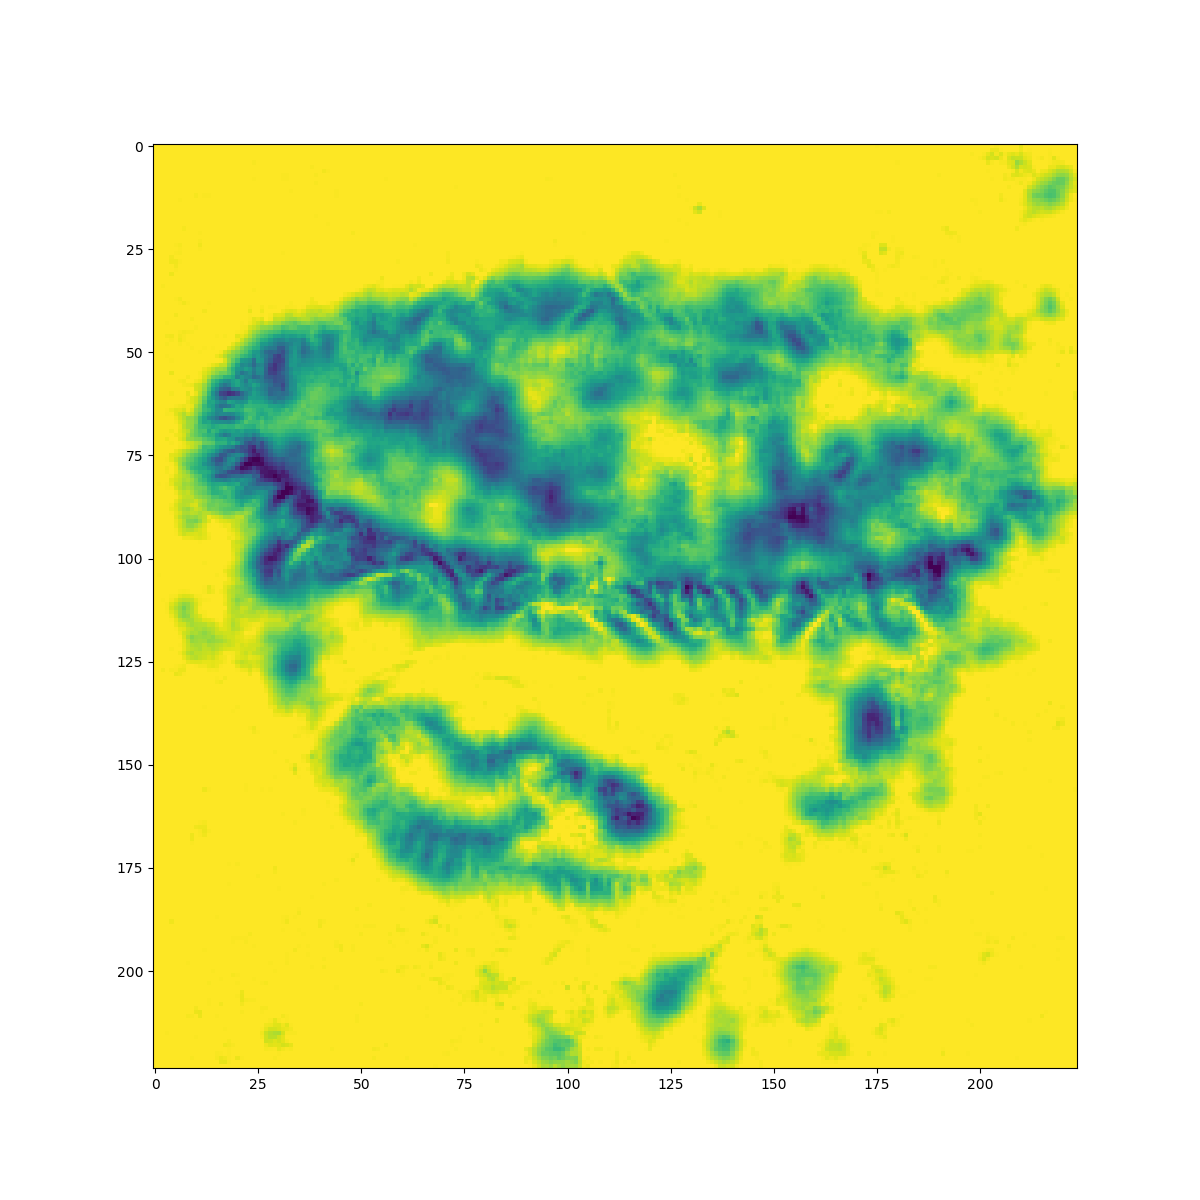

In [90]:
mask_path = '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_avg_blur_blank_noise/lr_0_l1_lambda_-5.00_tv_lambda_-3.00_beta_3.00_jitter_4_noise_-3.0_num_iters_300_tv2/9.npy'
f, ax = plt.subplots(1,1)
ax.imshow(np.load(mask_path))

/home/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10
/home/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


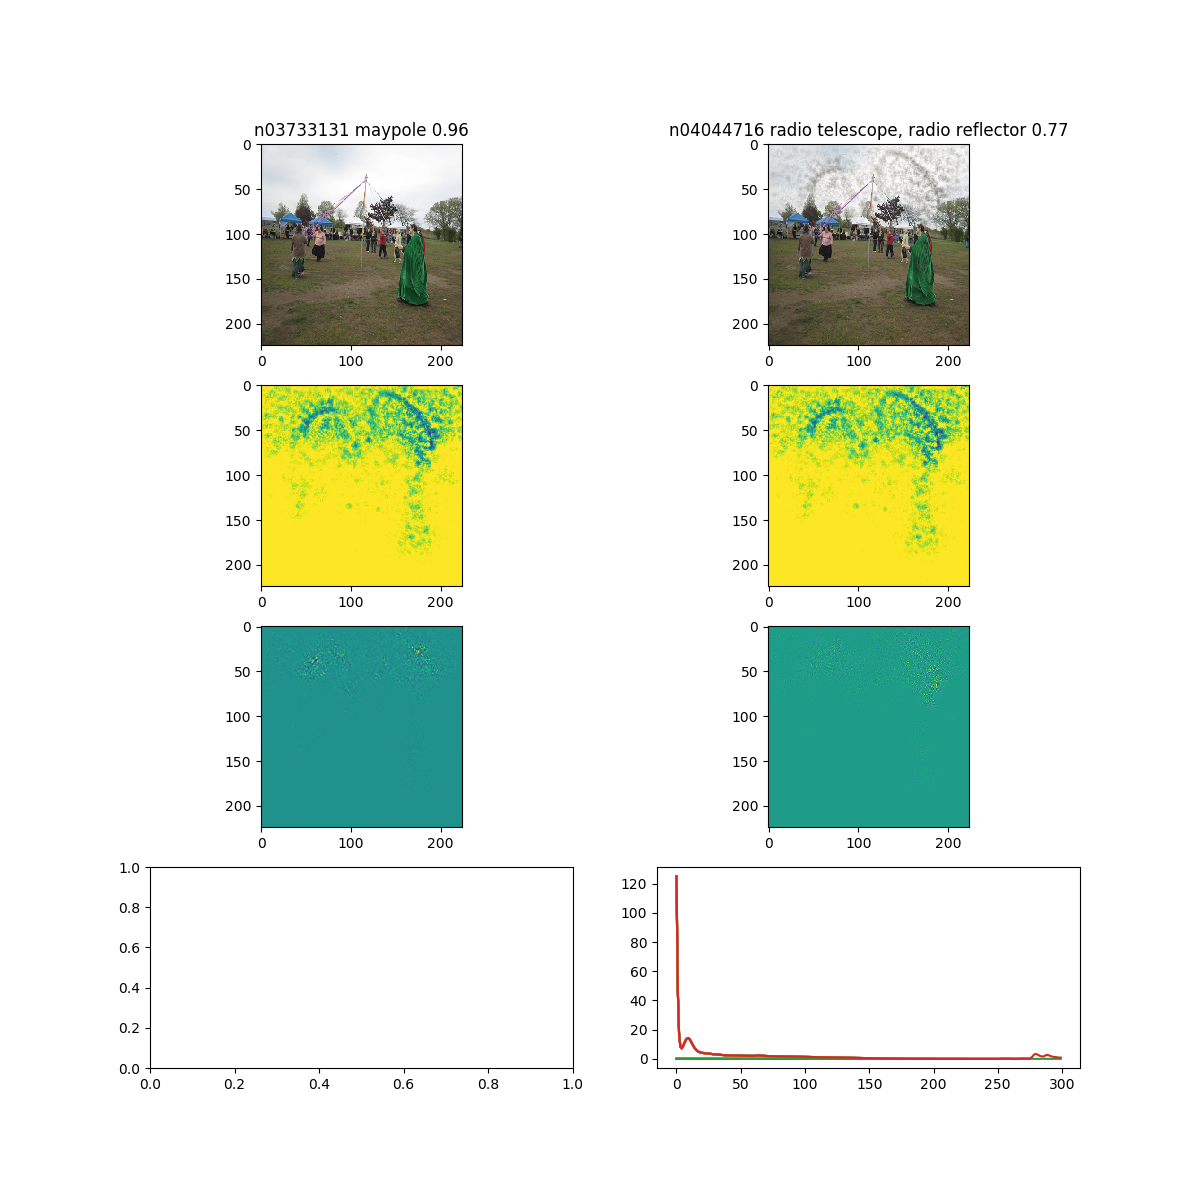

saved mask to /data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_mean_img/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_1_blur_mask_0_jitter_4_noise_-inf_num_iters_300_tv2/4.npy


<IPython.core.display.Javascript object>


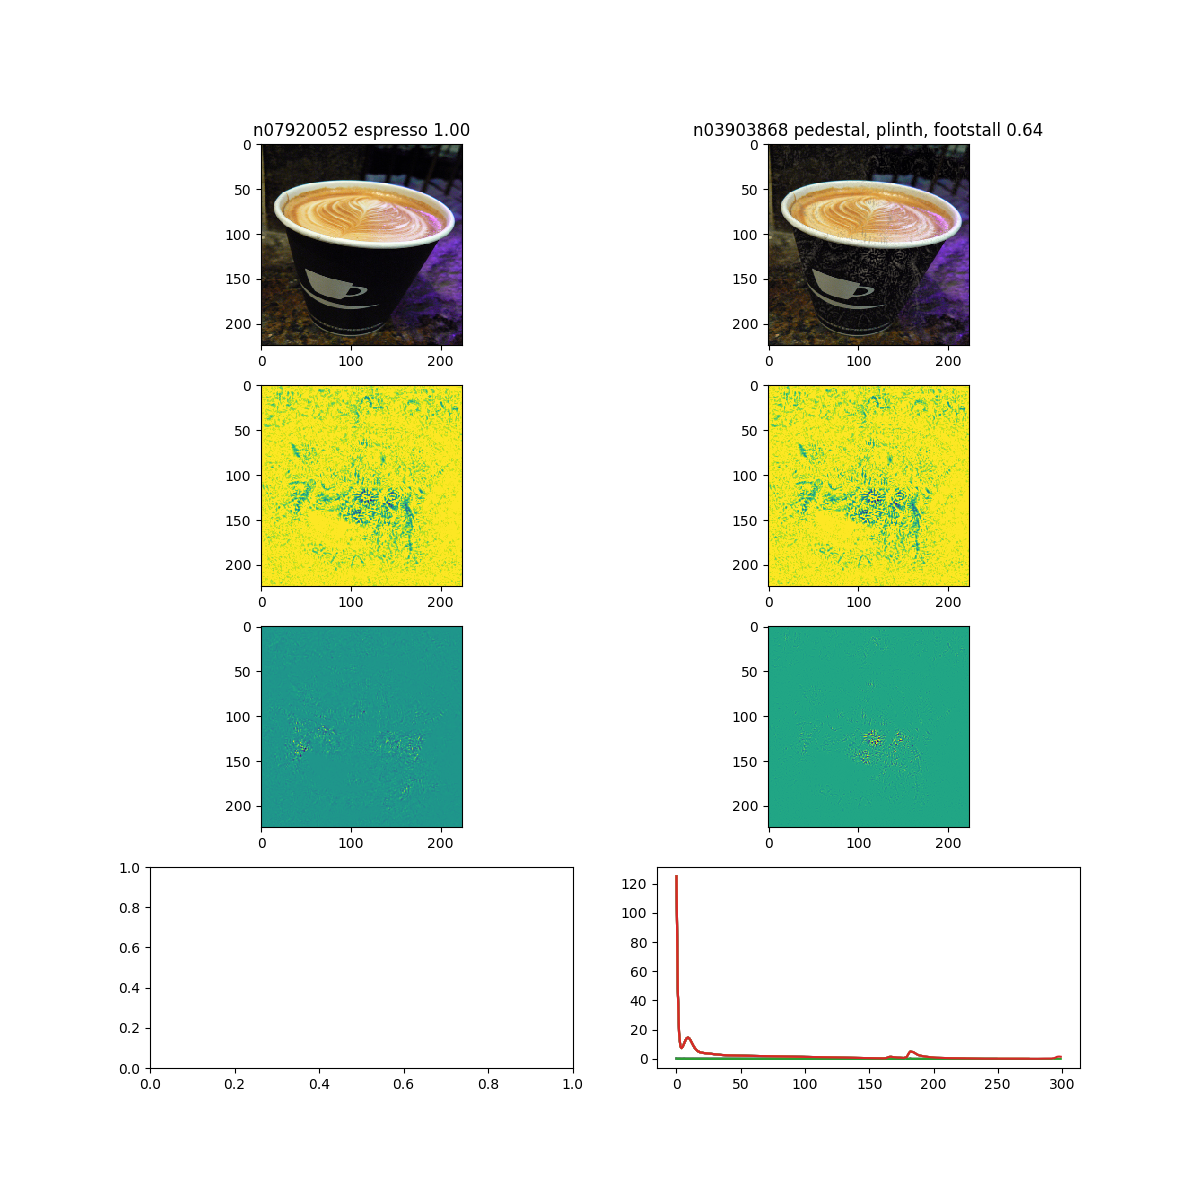

saved mask to /data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_mean_img/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_1_blur_mask_0_jitter_4_noise_-inf_num_iters_300_tv2/9.npy


In [92]:
num_iters = 300
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 3
jitter = 4
num_top = 5
noise = 0
null_type = 'mean_img'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 0
mask_scale = 1
    
net_transformer = get_ILSVRC_net_transformer(net)
for i in [4,9]:
    fig_path = os.path.join('/data/ruthfong/neural_coding/pycaffe_figs/%s_%s_given_grad_%d_norm_%d/min_top%d_%s_%s/lr_%.2f_l1_lambda_%.2f_l1_lambda2_%.2f_tv_lambda_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2/%d.png' % (
        net_type, data_desc, int(given_gradient), int(norm_score), num_top, end_layer, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters, i))
    mask_path = os.path.join('/data/ruthfong/neural_coding/pycaffe_results/%s_%s_given_grad_%d_norm_%d/min_top%d_%s_%s/lr_%.2f_l1_lambda_%.2f_tv_lambda_%.2f_l1_lambda_2_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2/%d.npy' % (
        net_type, data_desc, int(given_gradient), int(norm_score), num_top, end_layer, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters, i))


    if os.path.exists(mask_path):
        print '%s already exists so skipping' % mask_path
        continue

    #net = get_net(net_type)
    #net_transformer = get_ILSVRC_net_transformer(net)

    path = paths[i]
    img = net_transformer.preprocess('data', caffe.io.load_image(path))
    net.blobs['data'].data[...] = img
    net.forward()
    scores = np.squeeze(net.blobs['prob'].data)
    sorted_idx = np.argsort(scores)
    if given_gradient:
        target = np.zeros(scores.shape)
        if num_top == 0:
            target[labels[i]] = 1
        else:
            target[sorted_idx[:-(num_top+1):-1]] = 1
    else:
        if num_top == 0:
            target = np.array([labels[i]])
        else:
            target = sorted_idx[:-(num_top+1):-1]

    #mask_radius = test_circular_masks(net, paths[i], labels[i], plot = False)
    #mask_init = 1-create_blurred_circular_mask((net.blobs['data'].data.shape[2], net.blobs['data'].data.shape[3]),
    #                                     mask_radius, center = None, sigma = 10)

    optimize_mask(net, path, target, labels = labels_desc, given_gradient = given_gradient, norm_score = norm_score,
                        num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, l1_ideal = 1,
                        l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, mask_scale = mask_scale,
                        use_conv_norm= use_conv_norm, blur_mask = blur_mask, jitter = jitter,
                        null_type = null_type, mask_init = None, gpu = gpu, start_layer = None, end_layer = end_layer,
                        plot_step = 25, debug = False, fig_path = fig_path, mask_path = mask_path)

<IPython.core.display.Javascript object>


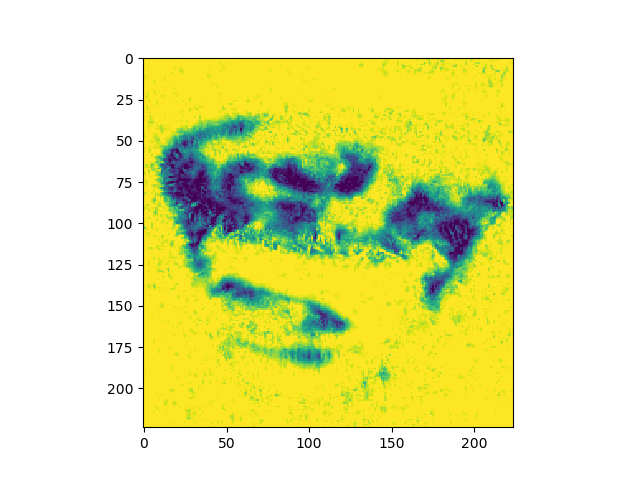

In [86]:
f, ax = plt.subplots(1,1)
ax.imshow(np.load('/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_1_blur_mask_0_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/9.npy'))